In [19]:
# CLASIFICACIÓN MULTIVARIABLE: RECONOCIMIENTO DE LETRAS DEL ALFABETO INGLÉS

# ## Descripción
# El dataset Letter Recognition (UCI Repository) contiene 20,000 ejemplos de letras mayúsculas (A-Z) con 16 características numéricas. Objetivo: entrenar un modelo de regresión logística multiclase (One-vs-All) para clasificar letras, mostrar efectividad con gráficos de costo y precisión, y validar con un split 80/20.

In [20]:
# Importar bibliotecas
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.style.use('default')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
## Carga y Exploración del Dataset
# Se carga el dataset Letter Recognition (20,000 ejemplos, 16 features, 26 clases balanceadas). Se verifica la forma y el balance.

In [22]:
# Cargar dataset
try:
    from ucimlrepo import fetch_ucirepo
    letter_recognition = fetch_ucirepo(id=59)
    X_features = letter_recognition.data.features
    y_target = letter_recognition.data.targets
    df = pd.concat([y_target, X_features], axis=1)
except ImportError:
    !pip install ucimlrepo
    from ucimlrepo import fetch_ucirepo
    letter_recognition = fetch_ucirepo(id=59)
    X_features = letter_recognition.data.features
    y_target = letter_recognition.data.targets
    df = pd.concat([y_target, X_features], axis=1)
except:
    df = pd.read_csv('/content/drive/MyDrive/Datasets/letter-recognition.data',
                     header=None,
                     names=['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix',
                            'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr',
                            'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx'])

# Información básica
print(f"Forma: {df.shape}, Clases: {df['lettr'].nunique()}")
class_distribution = df['lettr'].value_counts()
print("Balance (min/max):", class_distribution.min(), class_distribution.max())

Forma: (20000, 17), Clases: 26
Balance (min/max): 734 813


In [23]:
## Preprocesamiento con Pandas
# Se separan características (X) y etiquetas (y), codificando letras (A-Z) a números (0-25) y verificando balance.

In [24]:
# Separar datos
X = df.iloc[:, 1:].values
y_letters = df.iloc[:, 0].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_letters)

# Verificar balance
unique, counts = np.unique(y, return_counts=True)
print("Distribución numérica (ejemplos por clase):", dict(zip(label_encoder.classes_, counts)))

Distribución numérica (ejemplos por clase): {'A': np.int64(789), 'B': np.int64(766), 'C': np.int64(736), 'D': np.int64(805), 'E': np.int64(768), 'F': np.int64(775), 'G': np.int64(773), 'H': np.int64(734), 'I': np.int64(755), 'J': np.int64(747), 'K': np.int64(739), 'L': np.int64(761), 'M': np.int64(792), 'N': np.int64(783), 'O': np.int64(753), 'P': np.int64(803), 'Q': np.int64(783), 'R': np.int64(758), 'S': np.int64(748), 'T': np.int64(796), 'U': np.int64(813), 'V': np.int64(764), 'W': np.int64(752), 'X': np.int64(787), 'Y': np.int64(786), 'Z': np.int64(734)}


In [25]:
## Normalización de Características
# Se normalizan las características usando z-score para mejorar el entrenamiento.

In [26]:
def featureNormalize(X):
    X_norm = X.copy()
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    sigma[sigma == 0] = 1
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X_norm, mu, sigma = featureNormalize(X)
print("Normalización aplicada. Dimensiones:", X_norm.shape)

Normalización aplicada. Dimensiones: (20000, 16)


In [27]:
## División de Datos
# Se dividen los datos en 80% entrenamiento y 20% prueba, manteniendo el balance con stratify.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Entrenamiento: {X_train.shape[0]}, Prueba: {X_test.shape[0]}")

Entrenamiento: 16000, Prueba: 4000


In [29]:
## Implementación de Regresión Logística Vectorizada
# Se define la función sigmoide y el costo regularizado con gradiente para One-vs-All.

In [30]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def lrCostFunction(theta, X, y, lambda_):
    m = y.size
    h = sigmoid(X.dot(theta))
    h = np.clip(h, 1e-15, 1-1e-15)
    J = (1/m) * np.sum(-y * np.log(h) - (1-y) * np.log(1-h))
    theta_reg = theta.copy()
    theta_reg[0] = 0
    J += (lambda_/(2*m)) * np.sum(theta_reg**2)
    grad = (1/m) * X.T.dot(h - y) + (lambda_/m) * theta_reg
    return J, grad

In [31]:
## Implementación de Clasificación One-vs-All
# Se entrenan 26 clasificadores binarios, uno por clase, con regularización.

In [32]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    X_with_intercept = np.concatenate([np.ones((m, 1)), X], axis=1)
    all_theta = np.zeros((num_labels, n + 1))
    for c in range(num_labels):
        y_binary = (y == c).astype(int)
        initial_theta = np.zeros(n + 1)
        result = optimize.minimize(
            lrCostFunction, initial_theta, args=(X_with_intercept, y_binary, lambda_),
            jac=True, method='CG', options={'maxiter': 100})
        all_theta[c] = result.x
    return all_theta

lambda_reg = 0.1
all_theta = oneVsAll(X_train, y_train, 26, lambda_reg)

In [33]:
## Predicción One-vs-All
# Se predicen las clases basándose en las probabilidades máximas.

In [34]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    X_with_intercept = np.concatenate([np.ones((m, 1)), X], axis=1)
    probabilities = sigmoid(X_with_intercept.dot(all_theta.T))
    return np.argmax(probabilities, axis=1)

pred_train = predictOneVsAll(all_theta, X_train)
pred_test = predictOneVsAll(all_theta, X_test)

In [35]:
## Entrenamiento y Evaluación
# Se calcula la precisión en entrenamiento y prueba para evaluar el modelo.

In [36]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f"Precisión Entrenamiento: {accuracy_train:.4f}, Prueba: {accuracy_test:.4f}")

Precisión Entrenamiento: 0.7265, Prueba: 0.7262


In [37]:
## Gráficos de Costo y Precisión
# Se simula la convergencia del costo con gradiente descendente para algunas clases y se muestra la precisión por clase.

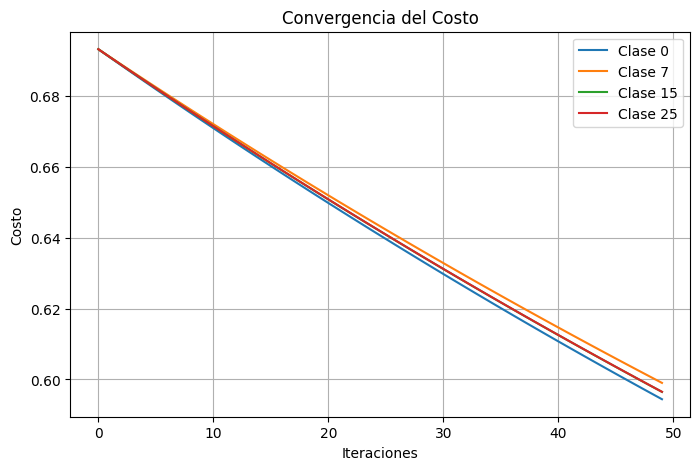

In [39]:
def analyzeConvergence(X, y, num_labels, lambda_, max_iter=50):
    m, n = X.shape
    X_with_intercept = np.concatenate([np.ones((m, 1)), X], axis=1)
    sample_classes = [0, 7, 15, 25]  # A, H, P, Z
    convergence_data = []
    for c in sample_classes:
        y_binary = (y == c).astype(int)
        theta = np.zeros(n + 1)
        costs = []
        for iteration in range(max_iter):
            cost, _ = lrCostFunction(theta, X_with_intercept, y_binary, lambda_)
            costs.append(cost)
            alpha = 0.01
            theta -= alpha * optimize.approx_fprime(theta, lambda x: lrCostFunction(x, X_with_intercept, y_binary, lambda_)[0], 1e-7)
        convergence_data.append({'class': c, 'costs': costs})
    return convergence_data

convergence_data = analyzeConvergence(X_train, y_train, 26, lambda_reg)
plt.figure(figsize=(8, 5))
for data in convergence_data:
    plt.plot(data['costs'], label=f'Clase {data["class"]}')
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.title('Convergencia del Costo')
plt.legend()
plt.grid(True)
plt.show()


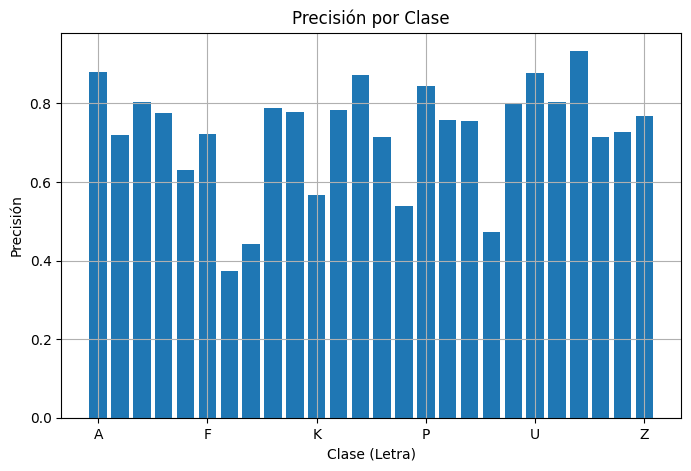

In [40]:
# Precisión por clase
class_accuracies = []
for i in range(26):
    mask = (y_test == i)
    if np.sum(mask) > 0:
        class_accuracies.append(np.mean(pred_test[mask] == i))
plt.figure(figsize=(8, 5))
plt.bar(range(26), class_accuracies)
plt.xlabel('Clase (Letra)')
plt.ylabel('Precisión')
plt.title('Precisión por Clase')
plt.xticks(range(0, 26, 5), [chr(ord('A') + i) for i in range(0, 26, 5)])
plt.grid(True)
plt.show()